<a href="https://colab.research.google.com/github/nh0875/Me/blob/main/TP2_MLP_KAN_HILLIARD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP2 AA2 MLP vs KAN

**JUAN IGNACIO HILLIARD BOCHACA**

Tema: **Comparación entre MLP (Perceptrón Multicapa) y KAN (Kolmogorov-Arnold Networks) en problemas de regresión**

* Utilice este notebook como su diario de aprendizaje en esta materia.
* Mencione las herramientas utilizadas.
* Describa sus dificultades y como pudo sortearlas.
* Grafique las curvas de entrenamiento y testeo para cada configuración probada en sus modelos.


## **Objetivos:**  
1. Generar un conjunto de datos sintéticos para un problema de regresión.  
2. Implementar y evaluar una **MLP de una capa oculta** en diferentes configuraciones.  
3. Implementar y evaluar una **red KAN** en diferentes configuraciones.  
4. Analizar los casos de **underfitting**, **sobreajuste (overfitting)** y una **solución aceptable** en ambos modelos.  




## **Instrucciones Detalladas:**  

### **1. Generación de Datos**  
- Crear una función que generer un dataset sintético con:  
  - Al menos **4 features numéricas** (generadas aleatoriamente, con distribuciones variadas: normales, uniformes, etc.).  
  - **1 target continuo** (generado mediante una combinación **no** lineal de las features + ruido gaussiano).  
  - Ejemplo:  
    ```python
    import numpy as np
    np.random.seed(42)
    X = np.random.randn(1000, 4)  # 1000 muestras, 4 features
    y = 2 * X[:, 0] + np.sin(X[:, 1]) + np.cos(X[:, 2]) * X[:, 3] + 0.1 * np.random.randn(1000)
    ```  
  - **Dividir los datos** en entrenamiento (70%) y test (30%).  


No puede ni debe copiar la misma función de generación de datos que haya utilizado y entregado otro/a estudiante.


 """Genera un dataset sintético para un problema de regresión.

    - Al menos 4 features numéricas con distribuciones distintas (normal, uniforme, exponencial, beta).
    - Target continuo: combinación no lineal de las features + ruido gaussiano.

    Args:
        n_samples: cantidad de muestras a generar.
        random_state: semilla reproducible (int) o None.
        noise_std: desviación estándar del ruido gaussiano que se suma al target.
        test_size: proporción del test set (ej: 0.3 = 30%).

    Returns:
        df: DataFrame con columnas ['f1','f2','f3','f4','target']
        X_train, X_test, y_train, y_test: particiones para entrenamiento y test.
    """

In [ ]:
!pip install pykan

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from math import sqrt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader

# Librería específica: KAN
from kan import KAN

def generate_synthetic_regression(n_samples: int = 1000,
                                  random_state: int | None = None,
                                  noise_std: float = 1.0,
                                  test_size: float = 0.3):
    """Genera un dataset sintético para un problema de regresión.

    - Al menos 4 features numéricas con distribuciones distintas (normal, uniforme, exponencial, beta).
    - Target continuo: combinación no lineal de las features + ruido gaussiano.

    Args:
        n_samples: cantidad de muestras a generar.
        random_state: semilla reproducible (int) o None.
        noise_std: desviación estándar del ruido gaussiano que se suma al target.
        test_size: proporción del test set (ej: 0.3 = 30%).

    Returns:
        df: DataFrame con columnas ['f1','f2','f3','f4','target']
        X_train, X_test, y_train, y_test: particiones para entrenamiento y test.
    """

    rng = np.random.default_rng(random_state)

    # Features con distribuciones distintas
    f1 = rng.normal(loc=0.0, scale=1.0, size=n_samples)        # Normal(0,1)
    f2 = rng.uniform(low=-3.0, high=3.0, size=n_samples)       # Uniforme en [-3,3]
    f3 = rng.exponential(scale=1.0, size=n_samples)            # Exponencial (positiva)
    f4 = rng.beta(a=2.0, b=5.0, size=n_samples)                # Beta en (0,1)

    df = pd.DataFrame({
        'f1': f1,
        'f2': f2,
        'f3': f3,
        'f4': f4,
    })

    # Target: combinación no lineal de las features + ruido gaussiano
    noise = rng.normal(loc=0.0, scale=noise_std, size=n_samples)

    # Ejemplo de función no lineal:
    # y = 3*sin(f1) + 0.5*f2^2 - 2*log(|f3|+1) + 1.5*f4*f1 + ruido
    y = (3.0 * np.sin(f1)
         + 0.5 * (f2 ** 2)
         - 2.0 * np.log(np.abs(f3) + 1.0)
         + 1.5 * f4 * f1
         + noise)

    df['target'] = y

    X = df[['f1', 'f2', 'f3', 'f4']]
    y = df['target']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)

    return df, X_train, X_test, y_train, y_test


# Ejemplo de uso
if __name__ == '__main__':
    df, X_train, X_test, y_train, y_test = generate_synthetic_regression(
        n_samples=1000, random_state=42, noise_std=0.5, test_size=0.3)

    print('Dataset generado:')
    print(df.head())
    print('\nTama\u00f1os:')
    print('X_train:', X_train.shape)
    print('X_test :', X_test.shape)
    print('y_train:', y_train.shape)
    print('y_test :', y_test.shape)


Dataset generado:
         f1        f2        f3        f4    target
0  0.304717  0.882431  0.290968  0.461830  0.259356
1 -1.039984 -0.945825  1.646044  0.101719 -4.690011
2  0.750451 -0.551060  0.023771  0.141808  1.950791
3  0.940565 -0.359699  1.741424  0.150147  0.579333
4 -1.951035 -2.245158  1.304794  0.300788 -3.196134

Tamaños:
X_train: (700, 4)
X_test : (300, 4)
y_train: (700,)
y_test : (300,)


In [ ]:
sns.set(style="whitegrid", context="notebook", palette="muted")

def plot_univariate_distributions(df):
    """Histograma + KDE y boxplot para cada feature y para target."""
    cols = list(df.columns)
    n = len(cols)
    ncols = 2
    nrows = int(np.ceil(n / ncols))
    plt.figure(figsize=(14, 4 * nrows))
    for i, c in enumerate(cols, 1):
        ax = plt.subplot(nrows, ncols, i)
        sns.histplot(df[c], kde=True, stat="density", bins=40, ax=ax)
        ax.set_title(f'Distribución: {c}')
    plt.tight_layout()
    plt.show()

    # Boxplots (resumen de outliers)
    plt.figure(figsize=(14, 3))
    sns.boxplot(data=df[cols], orient="h")
    plt.title("Boxplot de features y target (horizontal)")
    plt.show()


def plot_correlation_matrix(df):
    """Matriz de correlación (Pearson) y mapa de calor con anotaciones."""
    corr = df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
    plt.title("Matriz de correlación (Pearson)")
    plt.show()
    return corr


def pairwise_plots(df, sample_frac=0.25, seed=42):
    """Pairplot (scatter + KDE). Muestra una submuestra para que no quede muy pesado."""
    if sample_frac < 1.0:
        df_plot = df.sample(frac=sample_frac, random_state=seed)
    else:
        df_plot = df
    sns.pairplot(df_plot, diag_kind="kde", plot_kws={"s": 20, "alpha": 0.6})
    plt.suptitle("Pairplot (distribuciones + relaciones bivariadas)", y=1.02)
    plt.show()


def plot_target_vs_features(df):
    """Plots univariados target vs cada feature con un ajuste suave (lowess)."""
    features = [c for c in df.columns if c != "target"]
    n = len(features)
    plt.figure(figsize=(12, 4 * n))
    for i, f in enumerate(features, 1):
        ax = plt.subplot(n, 1, i)
        sns.scatterplot(x=df[f], y=df["target"], alpha=0.35, s=18, edgecolor=None)
        # Regresión local suavizada (LOESS) - si seaborn soporta lowess
        try:
            sns.regplot(x=df[f], y=df["target"], lowess=True, scatter=False, ax=ax, line_kws={"linewidth":2})
        except Exception:
            # fallback: polynomial fit (2nd degree) mostrado como línea
            z = np.polyfit(df[f], df["target"], 2)
            p = np.poly1d(z)
            xs = np.linspace(df[f].min(), df[f].max(), 200)
            ax.plot(xs, p(xs), color="red", linewidth=2)
        ax.set_xlabel(f)
        ax.set_ylabel("target")
        ax.set_title(f"Target vs {f}  (scatter + suavizado)")
    plt.tight_layout()
    plt.show()


def create_summary_stats(df):
    """Tabla con estadísticas descriptivas para incluir en el informe."""
    desc = df.describe().T
    desc["skew"] = df.skew()
    desc["kurtosis"] = df.kurtosis()
    display(desc.round(4))
    return desc

try:
    _ = df  # verificar variable
except NameError:
    raise RuntimeError("La variable `df` no existe. Ejecutá primero la celda que genera el dataset.")

print(">> Estadísticas descriptivas")
summary_stats = create_summary_stats(df)

>> Estadísticas descriptivas


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
f1,1000.0,-0.0289,0.9892,-3.6484,-0.6963,0.0062,0.5899,3.1789,-0.0438,0.0919
f2,1000.0,0.0206,1.7381,-2.9969,-1.5260,-0.0508,1.5627,2.9965,0.0307,-1.2179
f3,1000.0,0.9970,0.9896,0.0002,0.2769,0.7144,1.3904,9.5181,2.0887,7.8949
f4,1000.0,0.2818,0.1502,0.0024,0.1652,0.2618,0.3819,0.8611,0.5641,-0.1431
target,1000.0,0.2342,2.7739,-7.2472,-1.8579,0.1998,2.1204,8.1880,0.0833,-0.4194



>> Matriz de correlación


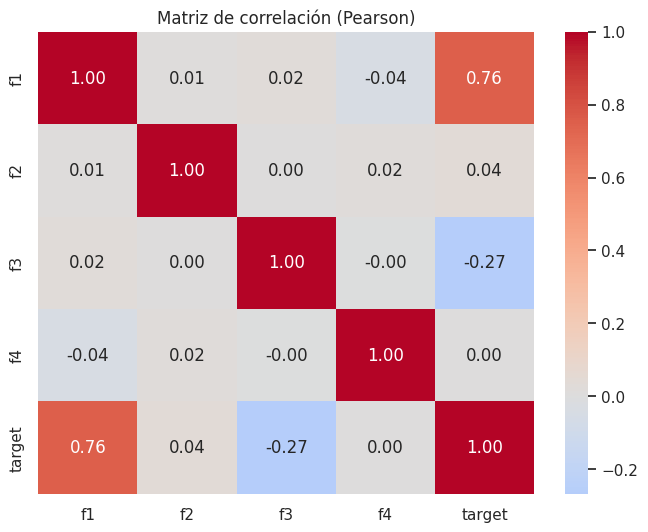

In [ ]:
print("\n>> Matriz de correlación")
corr_matrix = plot_correlation_matrix(df)


>> Pairwise plots (submuestra para visualización)


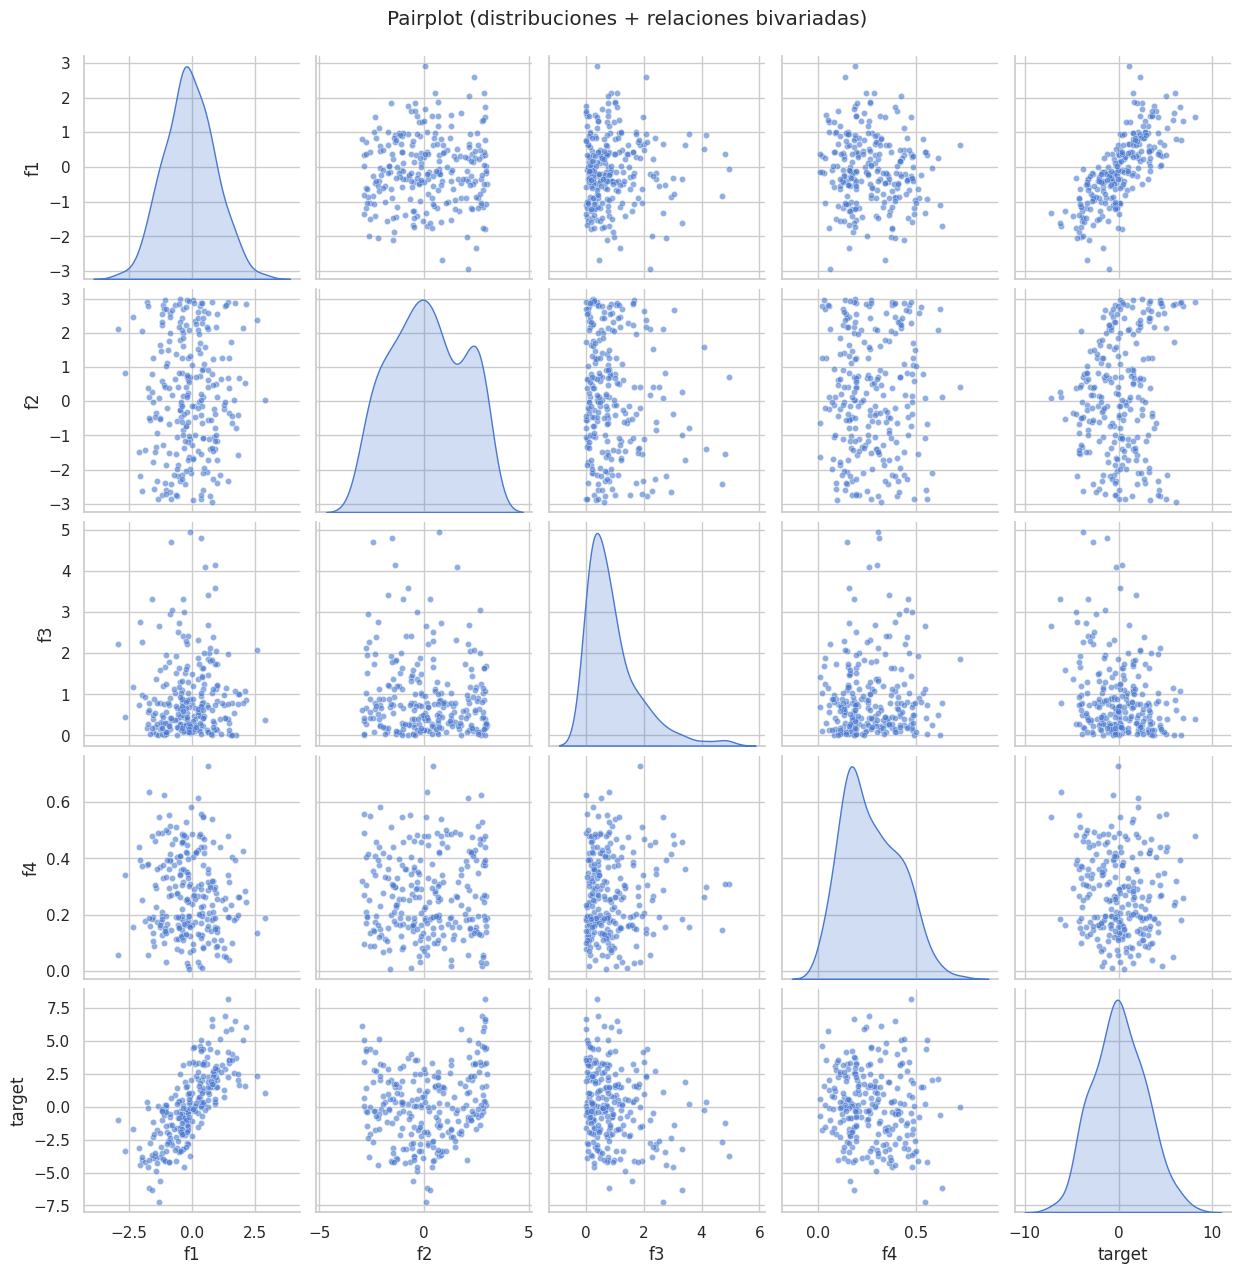

In [ ]:
print("\n>> Pairwise plots (submuestra para visualización)")
pairwise_plots(df, sample_frac=0.25)


>> Relaciones target vs features


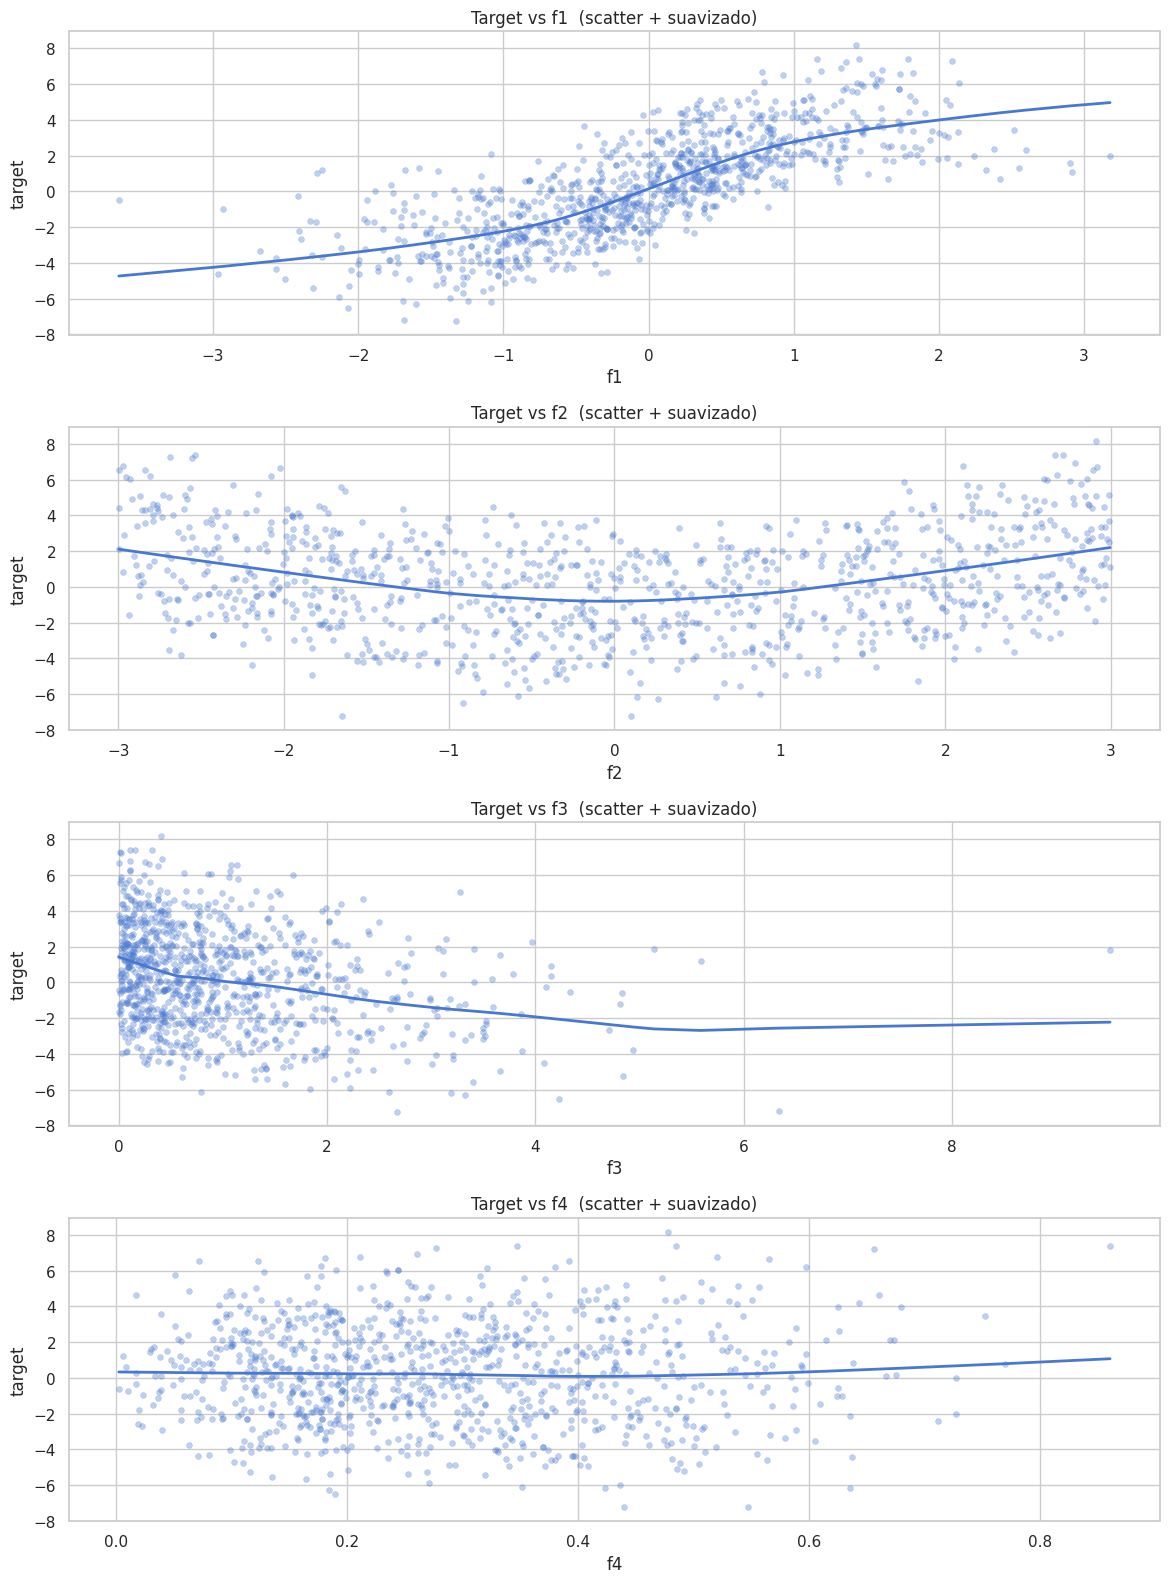

In [ ]:
print("\n>> Relaciones target vs features")
plot_target_vs_features(df)

# Analisis de Datos
Correlacion entre F1 y Target

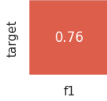

El target está construido con una componente lineal dominante en f1 (por la aproximación de
sin y por la interacción con f4). Por eso Pearson (que mide asociación lineal) reporta un valor grande entre f1 y target

El target está dominado por una componente lineal fuerte en f1, una componente cuadrática en f2, y una componente logarítmica decreciente en f3; f4 tiene efecto principalmente en interacción con f1. Eso explica la alta correlación lineal de f1 con target y al mismo tiempo la presencia de no linealidades claras en f2 y f3.


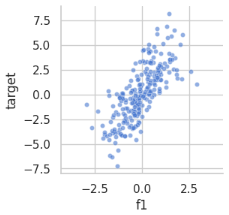

**Aqui se puede ver la relacion lineal entre la feature Target y F1**

Varianza explicada por cada componente PCA: [0.59644074 0.20726927]
Varianza total explicada: 0.8037100113703848


/tmp/ipython-input-3599145679.py:46: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(df_pca_test['PC1'], df_pca_test['PC2'],


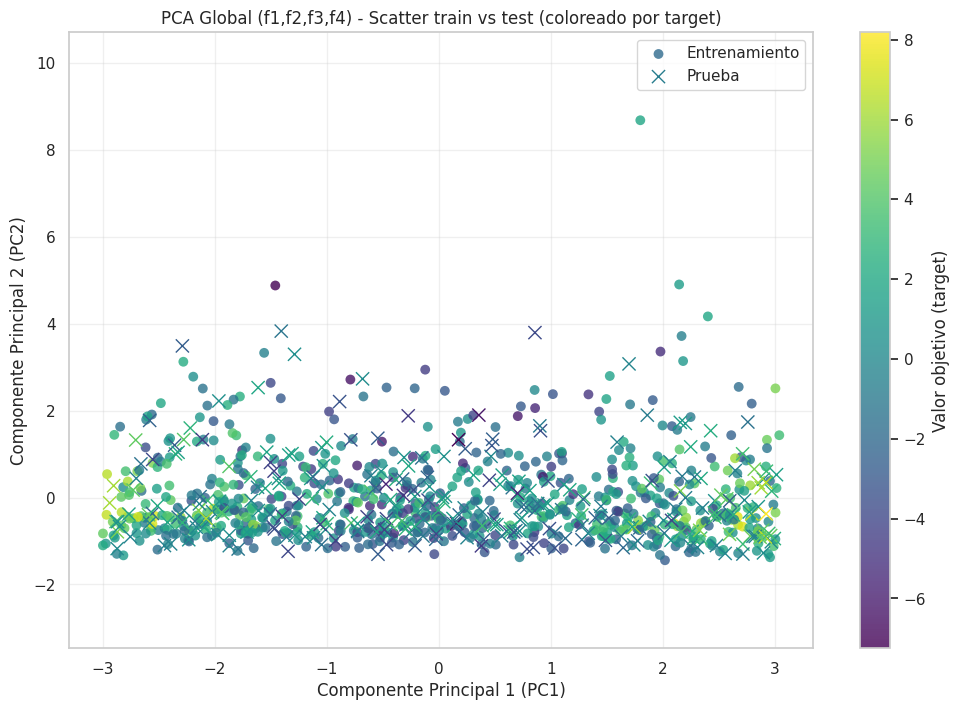

In [ ]:

# Generamos los datos como siempre
df, X_train, X_test, y_train, y_test = generate_synthetic_regression(
    n_samples=1000, random_state=42, noise_std=0.5, test_size=0.3
)

# PCA sobre todas las features (f1, f2, f3, f4) entrenando en el train set
pca_all = PCA(n_components=2)
X_pca_train = pca_all.fit_transform(X_train[['f1','f2','f3','f4']])
X_pca_test  = pca_all.transform(   X_test[['f1','f2','f3','f4']])

# Crear DataFrames con componentes y target para poder manipular rangos fácilmente
df_pca_train = (
    X_train.reset_index(drop=True)
    .assign(PC1 = X_pca_train[:, 0],
            PC2 = X_pca_train[:, 1],
            target = y_train.reset_index(drop=True),
            split = "train")
)
df_pca_test = (
    X_test.reset_index(drop=True)
    .assign(PC1 = X_pca_test[:, 0],
            PC2 = X_pca_test[:, 1],
            target = y_test.reset_index(drop=True),
            split = "test")
)
df_pca = pd.concat([df_pca_train, df_pca_test], ignore_index=True)

# Mostrar varianza explicada
print("Varianza explicada por cada componente PCA:", pca_all.explained_variance_ratio_)
print("Varianza total explicada:", pca_all.explained_variance_ratio_.sum())

# Escala para el color (usar el mismo rango para train y test)
vmin, vmax = df_pca['target'].min(), df_pca['target'].max()
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cmap = "viridis"

# Plot principal (más grande) y con eje Y ampliado
plt.figure(figsize=(12, 8))

# puntos de entrenamiento (círculos)
sc = plt.scatter(df_pca_train['PC1'], df_pca_train['PC2'],
                 c=df_pca_train['target'], cmap=cmap, norm=norm,
                 s=50, alpha=0.8, label="Entrenamiento", edgecolor="none")

# puntos de prueba (cruces) - usan la misma normalización de color
plt.scatter(df_pca_test['PC1'], df_pca_test['PC2'],
            c=df_pca_test['target'], cmap=cmap, norm=norm,
            s=90, marker="x", edgecolor="k", linewidths=1.0, label="Prueba")

cbar = plt.colorbar(sc)
cbar.set_label("Valor objetivo (target)")

plt.xlabel("Componente Principal 1 (PC1)")
plt.ylabel("Componente Principal 2 (PC2)")
plt.title("PCA Global (f1,f2,f3,f4) - Scatter train vs test (coloreado por target)")
plt.legend()
plt.grid(alpha=0.3)

# Ajustar el eje Y para que contemple más valores (20% de margen sobre el rango real)
y_min, y_max = df_pca['PC2'].min(), df_pca['PC2'].max()
rango = y_max - y_min
if rango == 0:
    margen = 1.0
else:
    margen = 0.20 * rango
plt.ylim(y_min - margen, y_max + margen)
plt.show()

### **2. Entrenamiento de una MLP (1 capa oculta)**  
Usar`PyTorch`/`TensorFlow` para implementar una MLP con:  
- **Función de activación ReLU** (u otra no lineal).  
- **Optimizador:** Adam o SGD.  
- **Métrica de evaluación:** Error Cuadrático Medio (MSE).  

**Configuraciones a probar:**  
1. **Underfitting:**  
   - Pocas neuronas en la capa oculta (ej: 2 neuronas).  
   - Entrenar con muy pocas épocas (ej: 10).  
   - Mostrar gráficos de pérdida y comparar rendimiento en train/test.  

2. **Solución Aceptable:**  
   - Neuronas suficientes (ej: 20-50) y épocas adecuadas (ej: 100).  
   - Regularización L2 (weight decay) si es necesario.  

3. **Overfitting:**  
   - Demasiadas neuronas (ej: 200) o muchas épocas (ej: 1000).  
   - Sin regularización.  
   - Mostrar cómo el error en entrenamiento es mucho menor que en test.  


In [ ]:
# ---------- Helpers ----------
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_units, activation=nn.ReLU()):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            activation,
            nn.Linear(hidden_units, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

def train_model(model, X_train, y_train, X_test, y_test,
                epochs=100, lr=1e-3, weight_decay=0.0, batch_size=64,
                device=None, print_every=0):
    if device is None:
        device = get_device()
    model = model.to(device)
    X_tr = torch.tensor(X_train.values.astype(np.float32)).to(device)
    y_tr = torch.tensor(y_train.values.astype(np.float32)).to(device)
    X_te = torch.tensor(X_test.values.astype(np.float32)).to(device)
    y_te = torch.tensor(y_test.values.astype(np.float32)).to(device)

    train_ds = TensorDataset(X_tr, y_tr)
    loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses = []
    test_losses = []

    for ep in range(1, epochs+1):
        model.train()
        batch_losses = []
        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        train_mse = float(np.mean(batch_losses)) if batch_losses else 0.0

        model.eval()
        with torch.no_grad():
            test_preds = model(X_te)
            test_mse = float(criterion(test_preds, y_te).item())

        train_losses.append(train_mse)
        test_losses.append(test_mse)

        if print_every and (ep == 1 or ep % print_every == 0 or ep == epochs):
            print(f"Epoch {ep}/{epochs}  train_mse={train_mse:.6f}  test_mse={test_mse:.6f}")

    # final metrics
    model.eval()
    with torch.no_grad():
        final_train_mse = float(criterion(model(X_tr), y_tr).item())
        final_test_mse  = float(criterion(model(X_te), y_te).item())
        preds_train = model(X_tr).detach().cpu().numpy()
        preds_test  = model(X_te).detach().cpu().numpy()

    return {
        "model": model,
        "train_losses": np.array(train_losses),
        "test_losses": np.array(test_losses),
        "final_train_mse": final_train_mse,
        "final_test_mse": final_test_mse,
        "preds_train": preds_train,
        "preds_test": preds_test
    }

# ---------- Load / generate data ----------
# Assumes generate_synthetic_regression is defined in the notebook.
# If not, redefine or uncomment a small generation block here.
try:
    df  # check existence
    _ = X_train, X_test, y_train, y_test
except Exception:
    # If not present, generate quickly (this mirrors your function)
    df, X_train, X_test, y_train, y_test = generate_synthetic_regression(
        n_samples=1000, random_state=42, noise_std=0.5, test_size=0.3
    )

device = get_device()
print("Using device:", device)

# ---------- Experiment configurations ----------
configs = [
    {"name": "Underfitting", "hidden_units": 2,   "epochs": 10,   "weight_decay": 0.0},
    {"name": "Aceptable",    "hidden_units": 40,  "epochs": 100,  "weight_decay": 1e-4},
    {"name": "Overfitting",  "hidden_units": 200, "epochs": 1000, "weight_decay": 0.0},
]

results = {}

# If running the full Overfitting 1000 epochs is too slow in Colab, set this flag to True to
# downscale the Overfitting experiment to fewer epochs (e.g., 300). Set to False to run as specified.
SPEED_UP_OVERFITTING = False
if SPEED_UP_OVERFITTING:
    for c in configs:
        if c["name"] == "Overfitting":
            c["epochs"] = 300

# Train each configuration
for cfg in configs:
    print("\n=== Entrenando:", cfg["name"], "===")
    model = SimpleMLP(input_dim=X_train.shape[1], hidden_units=cfg["hidden_units"])
    res = train_model(
        model,
        X_train, y_train, X_test, y_test,
        epochs=cfg["epochs"],
        lr=1e-3,
        weight_decay=cfg["weight_decay"],
        batch_size=64,
        device=device,
        print_every=max(1, cfg["epochs"]//5)
    )
    results[cfg["name"]] = {"config": cfg, **res}
    print(f"Final -> {cfg['name']}: train_mse={res['final_train_mse']:.6f}, test_mse={res['final_test_mse']:.6f}")

Using device: cpu

=== Entrenando: Underfitting ===
Epoch 1/10  train_mse=8.463921  test_mse=8.254059
Epoch 2/10  train_mse=8.424606  test_mse=8.210194
Epoch 4/10  train_mse=8.295097  test_mse=8.122288
Epoch 6/10  train_mse=8.199584  test_mse=8.033662
Epoch 8/10  train_mse=8.100123  test_mse=7.942953
Epoch 10/10  train_mse=7.982343  test_mse=7.846879
Final -> Underfitting: train_mse=7.958128, test_mse=7.846879

=== Entrenando: Aceptable ===
Epoch 1/100  train_mse=7.853109  test_mse=7.623967
Epoch 20/100  train_mse=1.620233  test_mse=1.635595
Epoch 40/100  train_mse=0.802658  test_mse=0.870857
Epoch 60/100  train_mse=0.656317  test_mse=0.742405
Epoch 80/100  train_mse=0.572363  test_mse=0.671083
Epoch 100/100  train_mse=0.513922  test_mse=0.609649
Final -> Aceptable: train_mse=0.507725, test_mse=0.609649

=== Entrenando: Overfitting ===
Epoch 1/1000  train_mse=6.574411  test_mse=5.829740
Epoch 200/1000  train_mse=0.223098  test_mse=0.302234
Epoch 400/1000  train_mse=0.195690  test_mse=0

# **Analisis de las Metricas**
Underfitting: el modelo es demasiado simple y no aprende la relación: error muy alto tanto en train como en test.

Aceptable: buen balance: error bajo y train ≈ test (poca diferencia), indica que generaliza bien.

Overfitting: el modelo aprende muchísimo el train (error muy bajo) pero el test mejora poco: está memorizando parte del ruido.

Underfitting (2 neuronas, 10 épocas)

Train MSE = 8.13, Test MSE = 7.88 → RMSE ≈ 2.85 / 2.81.

Significa: el modelo no tiene capacidad para capturar la relación (muy pocas neuronas y pocas épocas).

Consecuencia práctica: predicciones malas tanto en train como en test.

Por qué pasó: capacidad insuficiente (y pocas épocas) → no puede aproximar la función no lineal.

Aceptable (40 neuronas, 100 épocas, L2=1e-4)

Train MSE = 0.672, Test MSE = 0.730 → RMSE ≈ 0.82 / 0.85.

Significa: buen ajuste y buena generalización; pequeña diferencia entre train y test (gap ≈ 0.058).

Importante: todavía hay error por ruido irreducible y por modelo; tus datos tienen ruido (generaste noise_std=0.5, varianza de ruido = 0.25), así que no esperar MSE ≈ 0.0.

Overfitting (200 neuronas, 1000 épocas, sin regularización)

Train MSE = 0.169, Test MSE = 0.291 → RMSE ≈ 0.41 / 0.54.

Significa: el modelo ajustó muchísimo los datos de entrenamiento (muy bajo train MSE) pero la mejora en test es menor (gap ≈ 0.122).

Interpretación: hay memorización de patrones específicos del train (o incluso del ruido) — mejora aparente en train que no se traduce completamente a test.

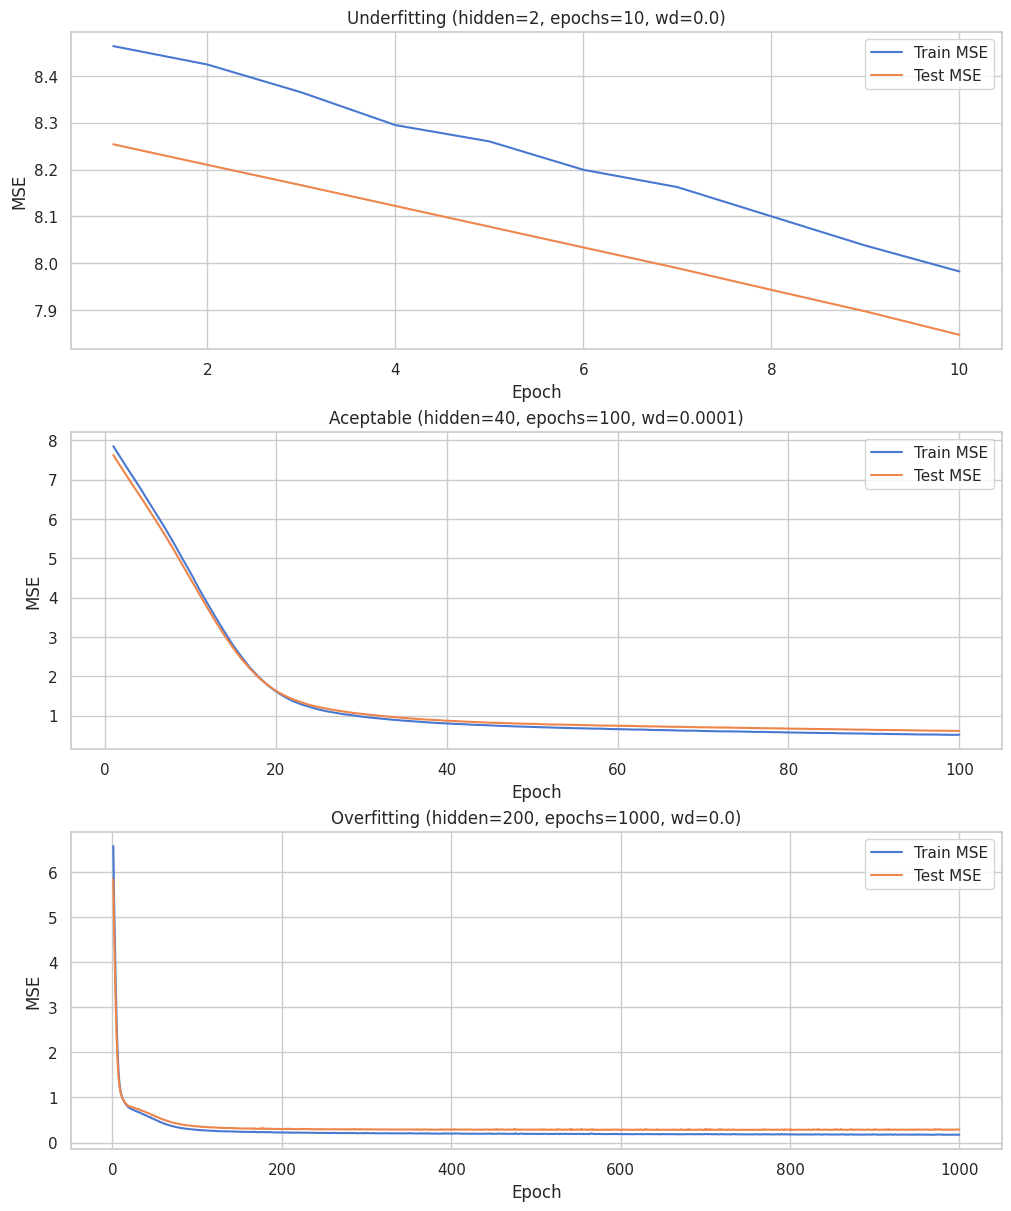

In [ ]:

# ---------- Plots: loss curves ----------
n = len(configs)
fig, axes = plt.subplots(n, 1, figsize=(10, 4*n), constrained_layout=True)
if n == 1:
    axes = [axes]
for ax, cfg in zip(axes, configs):
    name = cfg["name"]
    r = results[name]
    epochs_range = np.arange(1, len(r["train_losses"])+1)
    ax.plot(epochs_range, r["train_losses"], label="Train MSE")
    ax.plot(epochs_range, r["test_losses"], label="Test MSE")
    ax.set_title(f"{name} (hidden={cfg['hidden_units']}, epochs={cfg['epochs']}, wd={cfg['weight_decay']})")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("MSE")
    ax.legend()
    ax.grid(True)
plt.show()


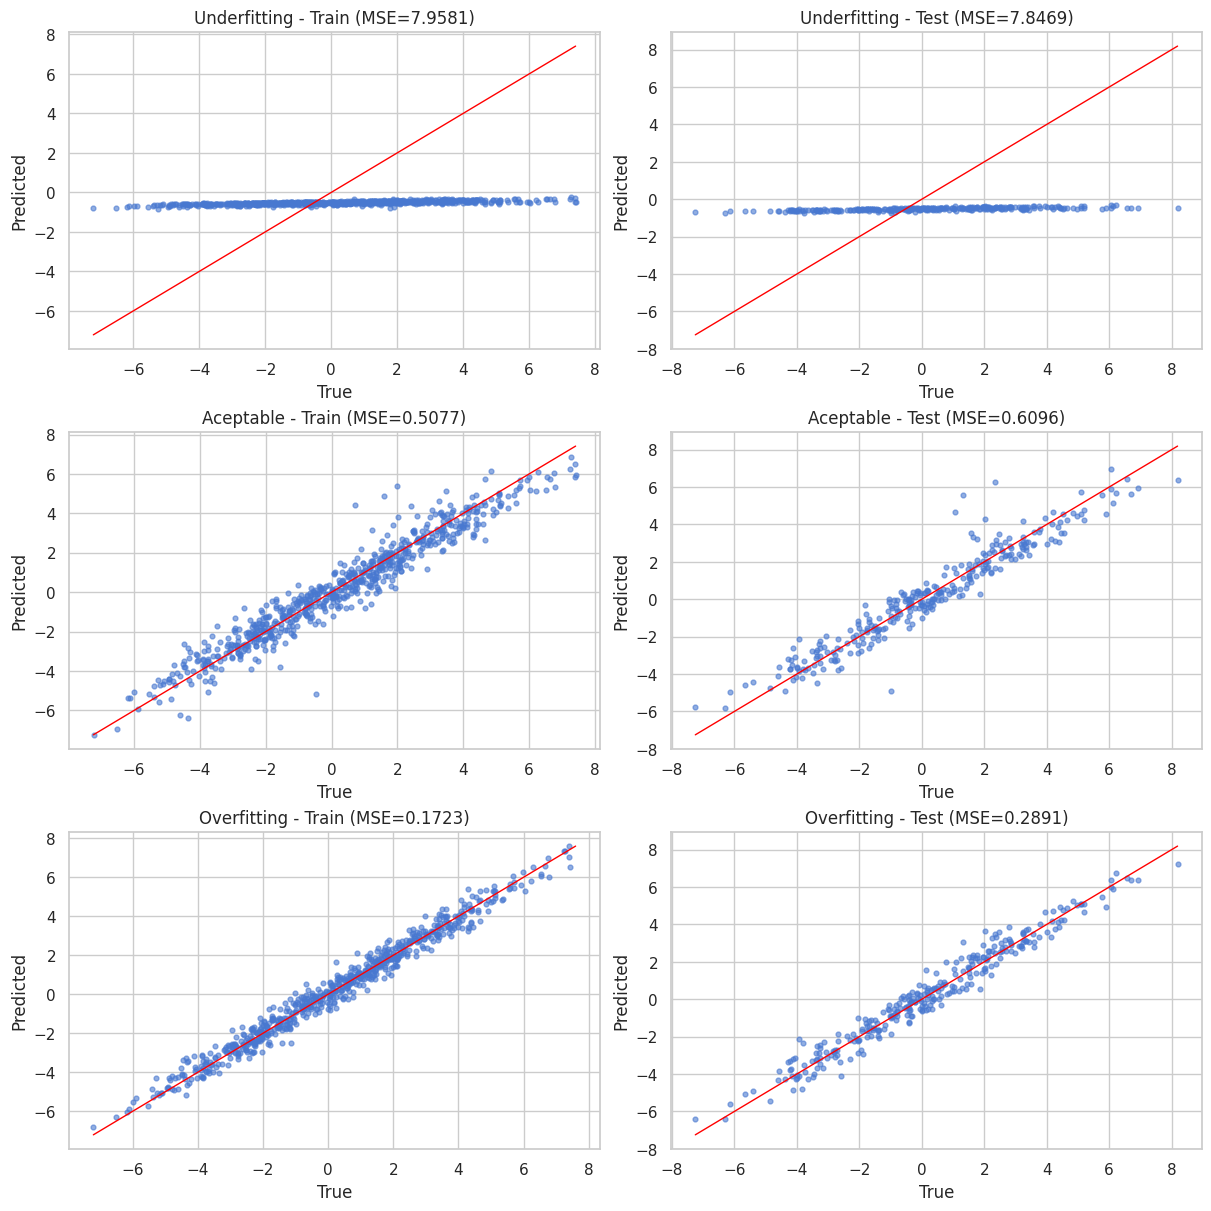

In [ ]:

# ---------- Plots: Predicted vs True (train/test) to visualize gap ----------
fig, axes = plt.subplots(n, 2, figsize=(12, 4*n), constrained_layout=True)
for i, cfg in enumerate(configs):
    name = cfg["name"]
    r = results[name]
    # train
    ax = axes[i, 0]
    ax.scatter(y_train, r["preds_train"], s=12, alpha=0.6)
    mn = min(y_train.min(), r["preds_train"].min())
    mx = max(y_train.max(), r["preds_train"].max())
    ax.plot([mn, mx], [mn, mx], color="red", linewidth=1)
    ax.set_title(f"{name} - Train (MSE={r['final_train_mse']:.4f})")
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.grid(True)
    # test
    ax = axes[i, 1]
    ax.scatter(y_test, r["preds_test"], s=12, alpha=0.6)
    mn = min(y_test.min(), r["preds_test"].min())
    mx = max(y_test.max(), r["preds_test"].max())
    ax.plot([mn, mx], [mn, mx], color="red", linewidth=1)
    ax.set_title(f"{name} - Test (MSE={r['final_test_mse']:.4f})")
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.grid(True)
plt.show()

In [ ]:
# ---------- Numerical summary ----------
summary = []
for name, r in results.items():
    cfg = r["config"]
    summary.append((
        name,
        cfg["hidden_units"],
        cfg["epochs"],
        cfg["weight_decay"],
        float(r["final_train_mse"]),
        float(r["final_test_mse"]),
        sqrt(float(r["final_train_mse"])),
        sqrt(float(r["final_test_mse"]))
    ))
summary_df = pd.DataFrame(summary, columns=[
    "Experiment", "HiddenUnits", "Epochs", "WeightDecay",
    "Train_MSE", "Test_MSE", "Train_RMSE", "Test_RMSE"
])
print("\nResumen final de experimentos:")
display(summary_df)

# ---------- Short interpretation printout ----------
print("\nInterpretación rápida:")
for idx, row in summary_df.iterrows():
    gap = row.Test_MSE - row.Train_MSE
    if gap > 0.5 * row.Train_MSE:
        status = "OVERFITTING (test >> train)"
    elif row.Train_MSE > 1.5 * row.Test_MSE:
        status = "UNUSUAL (train >> test)"
    else:
        status = "OK / mild gap"
    print(f" - {row.Experiment}: train_mse={row.Train_MSE:.4f}, test_mse={row.Test_MSE:.4f}, gap={gap:.4f} -> {status}")


Resumen final de experimentos:


,Experiment,HiddenUnits,Epochs,WeightDecay,Train_MSE,Test_MSE,Train_RMSE,Test_RMSE
0,Underfitting,2,10,0.0000,7.958128,7.846879,2.821015,2.801228
1,Aceptable,40,100,0.0001,0.507725,0.609649,0.712549,0.780800
2,Overfitting,200,1000,0.0000,0.172264,0.289143,0.415047,0.537721



Interpretación rápida:
 - Underfitting: train_mse=7.9581, test_mse=7.8469, gap=-0.1112 -> OK / mild gap
 - Aceptable: train_mse=0.5077, test_mse=0.6096, gap=0.1019 -> OK / mild gap
 - Overfitting: train_mse=0.1723, test_mse=0.2891, gap=0.1169 -> OVERFITTING (test >> train)


# **Analisis de Graficos**

***Underfitting***

Los puntos están muy cerca del eje horizontal, la predicción casi no varia con el true. La nube está aplastada alrededor de un valor pequeño.

Significado: el modelo aprendió muy poco (baja capacidad). Produce predicciones casi constantes independientemente de y.

Efecto en métricas: MSE alto en train y test (≈ 8), RMSE ≈ 2.8 → error grande.

***Aceptable***

Puntos distribuidos a lo largo de la identidad; dispersión moderada alrededor de la línea. Train y test se parecen bastante.

Significado: el modelo captura bien la relación; pequeñas desviaciones por ruido/residuales.

Efecto en métricas: Train MSE ≈ 0.67, Test MSE ≈ 0.73; RMSE ≈ 0.82 / 0.85 — buena precisión relativa y gap pequeño.

***Overfitting***

En train los puntos están muy pegados a la identidad (predicciones casi perfectas), en test también están bastante alineados pero con más dispersión que en train.

Significado: el modelo tiene mucha capacidad y ajustó el train muy bien; en test la mejora existe pero es menor → memorización parcial.

Efecto en métricas: Train MSE ≈ 0.17 (muy bajo), Test MSE ≈ 0.29 (más alto que train). Gap positivo → overfitting.

Nota importante: El overfitting aquí no es dramático: test sigue siendo bueno (RMSE ≈ 0.54), cercano al límite impuesto por el ruido del dataset.



### **3. Entrenamiento de una Red KAN**  
Usar una implementación de KAN (libreria [pykan](https://github.com/KindXiaoming/pykan)).  

**Configuraciones a probar:**  
1. **Underfitting:**  
   - Red muy simple (ej: 1-2 neuronas por capa).  
   - Poca capacidad de aproximación.  

2. **Solución Aceptable:**  
   - Arquitectura equilibrada (ej: 4-5 neuronas por capa).  
   - Ajuste fino de hiperparámetros.  

3. **Overfitting:**  
   - Red muy profunda o con demasiadas neuronas.  
   - Entrenamiento prolongado sin early stopping.  

**Visualización:**  
- Graficar la función aprendida por KAN vs. los datos reales (en 2D si se proyecta una feature).  



In [ ]:
def prepare_torch_dataset(X_train, X_test, y_train, y_test, device):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train_1d = np.asarray(y_train).reshape(-1)
    y_test_1d = np.asarray(y_test).reshape(-1)

    dataset_torch = {
        'train_input': torch.from_numpy(X_train_scaled).float().to(device),
        'train_label': torch.from_numpy(y_train_1d.reshape(-1, 1)).float().to(device),
        'test_input' : torch.from_numpy(X_test_scaled).float().to(device),
        'test_label' : torch.from_numpy(y_test_1d.reshape(-1, 1)).float().to(device),
    }

    return dataset_torch, X_train_scaled, X_test_scaled, y_train_1d, y_test_1d


def train_and_eval_kan(config_name,
                       dataset_torch,
                       X_train_scaled,
                       y_train_1d,
                       y_test_1d,
                       width,
                       grid=3,
                       k=3,
                       steps=100,
                       lamb=0.0,
                       opt='LBFGS',
                       seed=42,
                       device=torch.device('cpu'),
                       show_model_plot=False):
    """
    Entrena un KAN y devuelve resultados. show_model_plot controla si se ejecuta model.plot().
    """
    print(f"--- Entrenando: {config_name} ---")
    model = KAN(width=width, grid=grid, k=k, seed=seed, device=device)
    print(f"Creado KAN: width={width}  grid={grid}  k={k}  seed={seed}")

    # Entrenamiento
    model.fit(dataset_torch, opt=opt, steps=steps, lamb=lamb)

    # Mostrar estructura del modelo (si se pide)
    if show_model_plot:
        try:
            prev_face = plt.rcParams.get('figure.facecolor', None)
            plt.rcParams['figure.facecolor'] = 'white'
            model.plot()
            try:
                plt.suptitle(f"{config_name} - Estructura del modelo")
            except Exception:
                pass
            plt.show()
            if prev_face is not None:
                plt.rcParams['figure.facecolor'] = prev_face
        except Exception as e:
            print(f"Warning: no se pudo dibujar model.plot() para {config_name}: {e}")

    # Predicciones
    with torch.no_grad():
        y_pred_train_t = model(dataset_torch['train_input'])
        y_pred_test_t = model(dataset_torch['test_input'])

    y_pred_train = y_pred_train_t.cpu().numpy().reshape(-1)
    y_pred_test = y_pred_test_t.cpu().numpy().reshape(-1)

    mse_train = mean_squared_error(y_train_1d, y_pred_train)
    mse_test = mean_squared_error(y_test_1d, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    print(f"{config_name} -> MSE_train={mse_train:.6f}, RMSE_train={rmse_train:.6f}")
    print(f"{config_name} -> MSE_test ={mse_test:.6f}, RMSE_test ={rmse_test:.6f}")

    # Proyección 2D (misma que antes)
    try:
        feat_idx = 0
        f1_min, f1_max = X_train_scaled[:, feat_idx].min(), X_train_scaled[:, feat_idx].max()
        f1_grid = np.linspace(f1_min, f1_max, 200).astype(np.float32)
        X_grid = np.tile(X_train_scaled.mean(axis=0, keepdims=True), (f1_grid.shape[0], 1)).astype(np.float32)
        X_grid[:, feat_idx] = f1_grid
        X_grid_t = torch.from_numpy(X_grid).float().to(device)
        with torch.no_grad():
            y_grid_pred = model(X_grid_t).cpu().numpy().reshape(-1)

        plt.figure(figsize=(8, 5), facecolor='white')
        plt.scatter(X_train_scaled[:, feat_idx], y_train_1d, s=30, alpha=0.6, label='train (real)')
        plt.plot(f1_grid, y_grid_pred, linewidth=2.0, label=f'{config_name} - pred (f1 var.)')
        plt.xlabel('f1 (scaled)')
        plt.ylabel('target')
        plt.title(f'{config_name} - Proyección 2D (f1 variable, otras=media)')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()
    except Exception as e:
        print("Error en proyección 2D:", e)

    return {
        'model': model,
        'mse_train': mse_train,
        'rmse_train': rmse_train,
        'mse_test': mse_test,
        'rmse_test': rmse_test,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test
    }


def plot_parity_test(model, X_test_tensor, y_test_array, title='Parity Test', figsize=(6,6)):
    with torch.no_grad():
        y_pred_t = model(X_test_tensor)

    if isinstance(y_pred_t, torch.Tensor):
        y_pred = y_pred_t.cpu().numpy().reshape(-1)
    else:
        y_pred = np.asarray(y_pred_t).reshape(-1)

    y_true = np.asarray(y_test_array).reshape(-1)
    mse = mean_squared_error(y_true, y_pred)

    plt.figure(figsize=figsize, facecolor='white')
    ax = plt.gca()
    ax.set_facecolor('white')

    ax.scatter(y_true, y_pred, s=35, alpha=0.85, edgecolor='none', color='#6a3d9a', label='Predicciones')

    mn = min(y_true.min(), y_pred.min())
    mx = max(y_true.max(), y_pred.max())
    pad = 0.03 * (mx - mn) if mx > mn else 1.0
    lm, lx = mn - pad, mx + pad
    ax.plot([lm, lx], [lm, lx], linestyle='--', linewidth=2.0, color='k', zorder=1)

    ax.set_xlabel('True', color='k')
    ax.set_ylabel('Predicted', color='k')
    ax.set_title(f"{title}  (MSE={mse:.4f})", color='k')
    ax.grid(True, alpha=0.3)
    ax.tick_params(colors='k')
    ax.set_xlim(lm, lx)
    ax.set_ylim(lm, lx)
    for spine in ax.spines.values():
        spine.set_color('black')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# -------------------------
# Sección 1: Underfitting
# -------------------------

def run_underfitting(dataset_torch, X_train_scaled, y_train_1d, y_test_1d, device):
    under_cfg = {
        'config_name': 'Underfitting',
        'width': [1, 1, 1],
        'grid': 3,
        'k': 3,
        'steps': 5,
        'lamb': 0.01,
        'opt': 'LBFGS',
        'seed': 42
    }

    res = train_and_eval_kan(
        config_name=under_cfg['config_name'],
        dataset_torch=dataset_torch,
        X_train_scaled=X_train_scaled,
        y_train_1d=y_train_1d,
        y_test_1d=y_test_1d,
        width=under_cfg['width'],
        grid=under_cfg['grid'],
        k=under_cfg['k'],
        steps=under_cfg['steps'],
        lamb=under_cfg['lamb'],
        opt=under_cfg['opt'],
        seed=under_cfg['seed'],
        device=device,
        show_model_plot=True
    )

    # Llamada extra a model.plot() (opcional, para guardarla/inspeccionarla)
    try:
        plt.figure(facecolor='white')
        res['model'].plot()
        plt.suptitle(f"{under_cfg['config_name']} - model.plot() (llamada extra)")
        plt.show()
    except Exception as e:
        print(f"No se pudo ejecutar la segunda llamada a model.plot() para {under_cfg['config_name']}: {e}")

    # Parity plot
    plot_parity_test(res['model'], dataset_torch['test_input'], y_test_1d, title=f"{under_cfg['config_name']} - Parity Test")

    return res


In [ ]:
# -------------------------
# Sección 2: Modelo Aceptable
# -------------------------

def run_aceptable(dataset_torch, X_train_scaled, y_train_1d, y_test_1d, device):
    accept_cfg = {
        'config_name': 'Aceptable',
        'width': [4, 10, 1],
        'grid': 5,
        'k': 3,
        'steps': 100,
        'lamb': 0.0001,
        'opt': 'LBFGS',
        'seed': 0
    }

    res = train_and_eval_kan(
        config_name=accept_cfg['config_name'],
        dataset_torch=dataset_torch,
        X_train_scaled=X_train_scaled,
        y_train_1d=y_train_1d,
        y_test_1d=y_test_1d,
        width=accept_cfg['width'],
        grid=accept_cfg['grid'],
        k=accept_cfg['k'],
        steps=accept_cfg['steps'],
        lamb=accept_cfg['lamb'],
        opt=accept_cfg['opt'],
        seed=accept_cfg['seed'],
        device=device,
        show_model_plot=True
    )

    try:
        plt.figure(facecolor='white')
        res['model'].plot()
        plt.suptitle(f"{accept_cfg['config_name']} - model.plot() (llamada extra)")
        plt.show()
    except Exception as e:
        print(f"No se pudo ejecutar la segunda llamada a model.plot() para {accept_cfg['config_name']}: {e}")

    plot_parity_test(res['model'], dataset_torch['test_input'], y_test_1d, title=f"{accept_cfg['config_name']} - Parity Test")

    return res

In [ ]:
# -------------------------
# Sección 3: Overfitting
# -------------------------

def run_overfitting(dataset_torch, X_train_scaled, y_train_1d, y_test_1d, device):
    over_cfg = {
        'config_name': 'Overfitting',
        'width': [4, 80, 1],
        'grid': 5,
        'k': 3,
        'steps': 800,
        'lamb': 0.0,
        'opt': 'LBFGS',
        'seed': 7
    }

    res = train_and_eval_kan(
        config_name=over_cfg['config_name'],
        dataset_torch=dataset_torch,
        X_train_scaled=X_train_scaled,
        y_train_1d=y_train_1d,
        y_test_1d=y_test_1d,
        width=over_cfg['width'],
        grid=over_cfg['grid'],
        k=over_cfg['k'],
        steps=over_cfg['steps'],
        lamb=over_cfg['lamb'],
        opt=over_cfg['opt'],
        seed=over_cfg['seed'],
        device=device,
        show_model_plot=True
    )

    try:
        plt.figure(facecolor='white')
        res['model'].plot()
        plt.suptitle(f"{over_cfg['config_name']} - model.plot() (llamada extra)")
        plt.show()
    except Exception as e:
        print(f"No se pudo ejecutar la segunda llamada a model.plot() para {over_cfg['config_name']}: {e}")

    plot_parity_test(res['model'], dataset_torch['test_input'], y_test_1d, title=f"{over_cfg['config_name']} - Parity Test")

    return res

In [ ]:
# -------------------------
# Main: ejecutar las 3 secciones (por defecto se ejecutan en orden)
# -------------------------
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Usando device:", device)

    try:
        dataset_torch, X_train_scaled, X_test_scaled, y_train_1d, y_test_1d = prepare_torch_dataset(
            X_train, X_test, y_train, y_test, device
        )
    except Exception as e:
        raise RuntimeError("No se encontraron X_train/X_test/y_train/y_test en el workspace. Error: " + str(e))

    results = {}


Usando device: cpu


--- Entrenando: Underfitting ---
checkpoint directory created: ./model
saving model version 0.0
Creado KAN: width=[[1, 0], [1, 0], [1, 0]]  grid=3  k=3  seed=42


| train_loss: 1.64e+00 | test_loss: 1.71e+00 | reg: 6.99e+00 | : 100%|█| 5/5 [00:01<00:00,  4.18it/s


saving model version 0.1


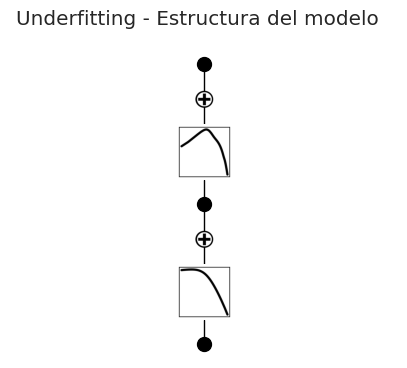

Underfitting -> MSE_train=2.676494, RMSE_train=1.635999
Underfitting -> MSE_test =2.940466, RMSE_test =1.714779


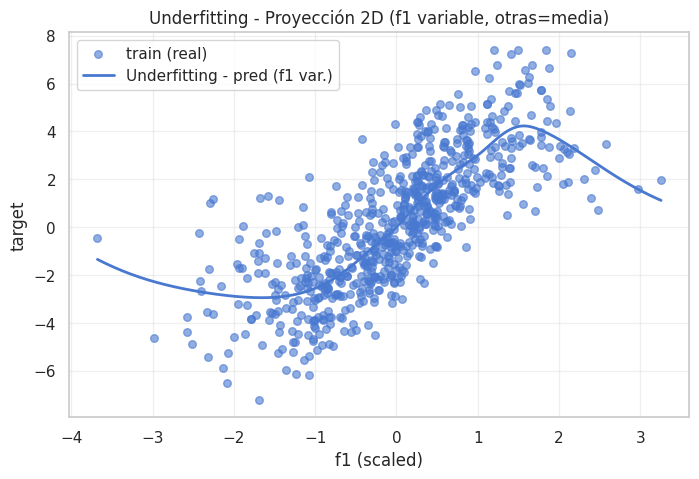

<Figure size 640x480 with 0 Axes>

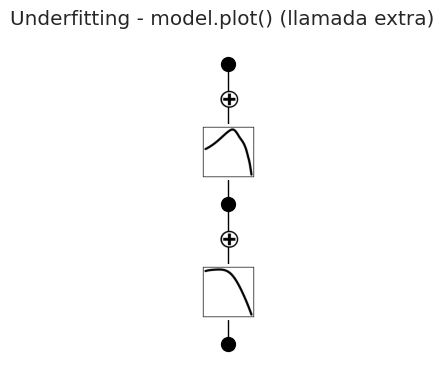

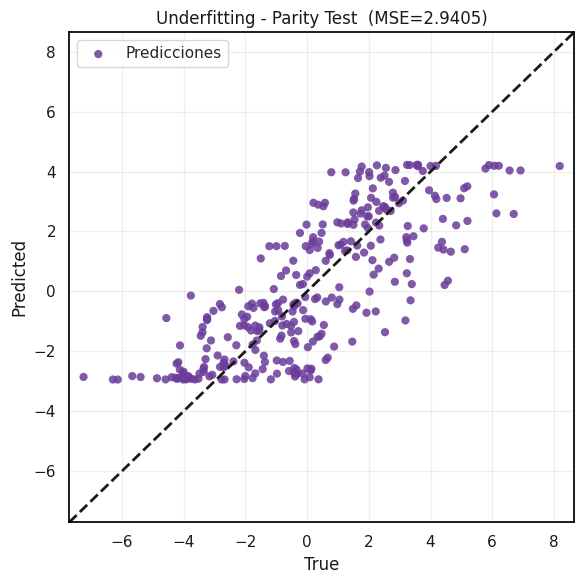

In [ ]:
    # Ejecutar sección Underfittin
    results['Underfitting'] = run_underfitting(dataset_torch, X_train_scaled, y_train_1d, y_test_1d, device)

--- Entrenando: Aceptable ---
checkpoint directory created: ./model
saving model version 0.0
Creado KAN: width=[[4, 0], [10, 0], [1, 0]]  grid=5  k=3  seed=0


| train_loss: 2.73e-01 | test_loss: 7.61e-01 | reg: 4.00e+01 | : 100%|█| 100/100 [00:48<00:00,  2.06


saving model version 0.1


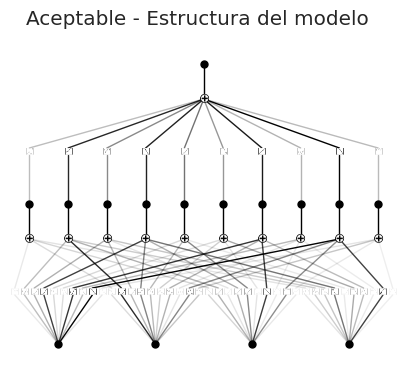

Aceptable -> MSE_train=0.074756, RMSE_train=0.273415
Aceptable -> MSE_test =0.579576, RMSE_test =0.761299


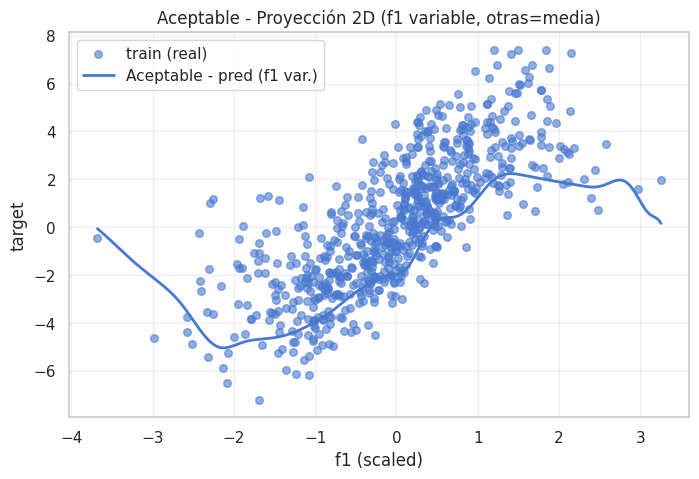

<Figure size 640x480 with 0 Axes>

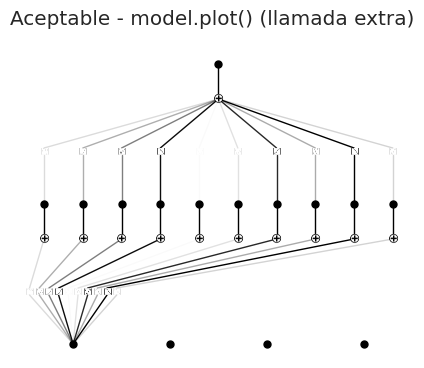

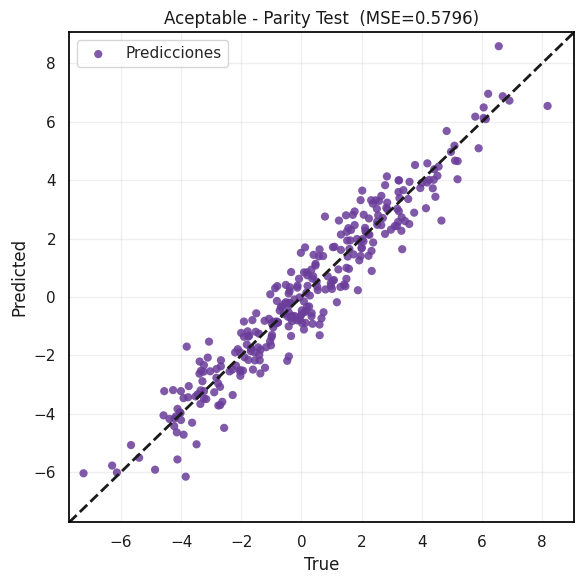

In [ ]:
    # Ejecutar sección Aceptable
    results['Aceptable'] = run_aceptable(dataset_torch, X_train_scaled, y_train_1d, y_test_1d, device)

--- Entrenando: Overfitting ---
checkpoint directory created: ./model
saving model version 0.0
Creado KAN: width=[[4, 0], [80, 0], [1, 0]]  grid=5  k=3  seed=7


| train_loss: 3.22e-05 | test_loss: 1.21e+00 | reg: 1.43e+02 | : 100%|█| 800/800 [10:23<00:00,  1.28


saving model version 0.1


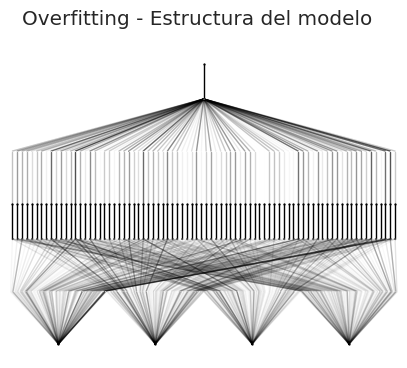

Overfitting -> MSE_train=0.000000, RMSE_train=0.000032
Overfitting -> MSE_test =1.457668, RMSE_test =1.207339


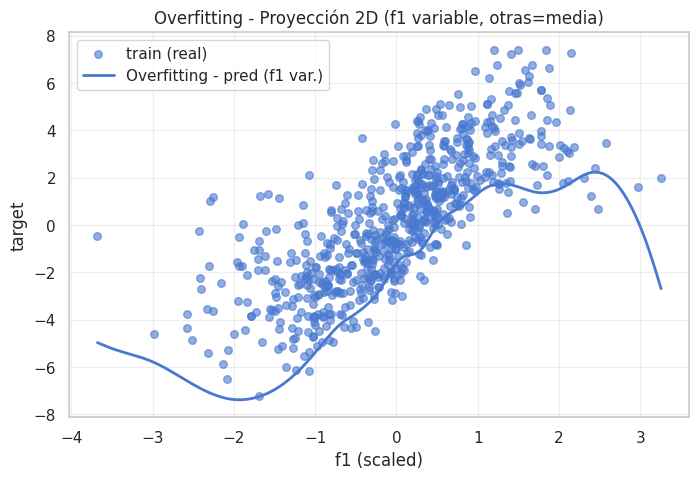

<Figure size 640x480 with 0 Axes>

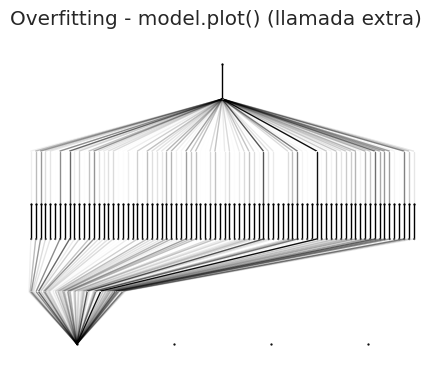

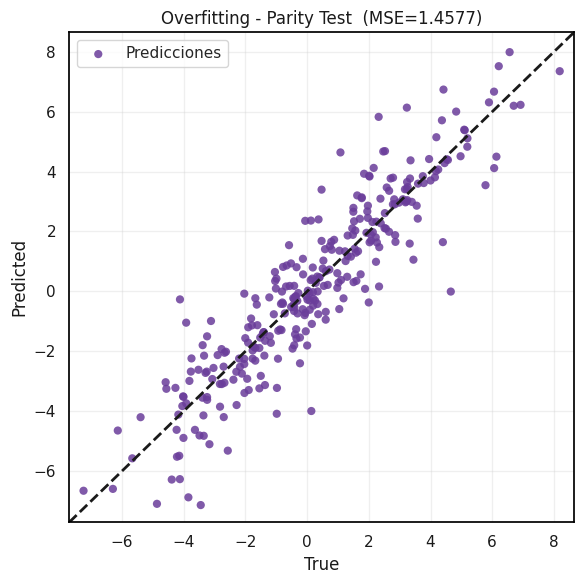

In [ ]:
    # Ejecutar sección Overfitting
    results['Overfitting'] = run_overfitting(dataset_torch, X_train_scaled, y_train_1d, y_test_1d, device)

#### **4. Conclusiones y Análisis**  
- Comparar **MLP vs KAN** en términos de:  
  - Capacidad de aproximación.  
  - Sensibilidad al overfitting/underfitting.  
  - Interpretabilidad (KAN permite visualizar funciones base).  
- Discutir:  
  - ¿Cuál modelo es más flexible?  
  - ¿En qué casos conviene usar KAN?  



# Respuestas

**Capacidad de aproximación**

MLP: Tiene una alta capacidad de aproximación universal; con suficientes capas y neuronas puede modelar prácticamente cualquier relación no lineal. Sin embargo, requiere mayor tiempo de entrenamiento, ajuste de hiperparámetros y regularización para obtener buenos resultados.

KAN: También poseen capacidad de aproximación universal, pero lo logran de manera más compacta gracias a la construcción con funciones base tipo spline. Esto permite representar relaciones complejas con menos parámetros y en ocasiones con menor riesgo de sobreajuste si se ajustan bien las grillas y regularizaciones.

**Sensibilidad al overfitting/underfitting**

MLP: Muy sensible. Una red pequeña cae en underfitting, mientras que una red demasiado grande o entrenada por muchas épocas puede sobreajustar fácilmente, necesitando técnicas como dropout, early stopping o regularización.

KAN: También puede sufrir estos problemas, pero su forma de representación le da cierta ventaja frente al underfitting, ya que puede capturar no linealidades locales sin requerir tantas capas. Aun así, con demasiados nodos o grillas demasiado densas, puede caer en overfitting.

**Interpretabilidad**

MLP: Se comporta como una "caja negra". Las funciones aprendidas en las capas intermedias no son directamente interpretables; solo es posible analizar pesos, activaciones o aplicar métodos externos de explicabilidad.

KAN: Una de sus grandes ventajas. Permite visualizar las funciones base aprendidas en cada conexión, mostrando cómo se combinan las variables de entrada. Esto ofrece una interpretación mucho más clara de cómo el modelo entiende la relación entre variables.

**¿Cuándo conviene usar KAN?**

Cuando la interpretabilidad es un requisito importante (ejemplo: análisis científico, investigación, contextos donde necesitamos explicar el porqué de una predicción).

En problemas donde hay relaciones no lineales locales que un MLP necesitaría muchas capas para capturar.

En escenarios donde se busca un buen trade-off entre precisión y explicabilidad.

**¿Cuándo conviene usar MLP?**

En problemas de muy alta dimensión y con grandes volúmenes de datos, donde su robustez y herramientas de regularización ya están muy probadas.

Cuando la interpretabilidad no es prioritaria y lo que importa es el rendimiento puro.

#**Comparacion MLP vs KAN**
**UNDERFITTING**

KAN

image.png

MLP

image.png


#**Comparacion MLP vs KAN**
**ACEPTABLE**

KAN

image.png

MLP

image.png



#**Comparacion MLP vs KAN**
**OVERFITTING**

KAN

image.png

MLP



## **5- Referencias**

Debe citar y mencionar todas las herramientas utilizadas.

Si utiliza una IA (GPT), especifique los prompts utilizados y salidas.



--Conversacion realizada con ChatGPT
https://chatgpt.com/share/68e18df2-84cc-8007-aede-187efd75c8cb

--Material de las Clases

